# Plotting horizontal wells in 3D space

To read in the well log LAS file you need to install `lasio` which is what the next cell does

In [ ]:
! pip install lasio

Then we import `lasio`, `numpy`, and `pandas` for managing our data and `matplotlib` for plotting up our well in 3D

In [1]:
import lasio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Read in the `.las` file using `lasio` and assign it to variable `l`, we will then print out the curve mnemonics to see what curves are in this well log

In [2]:
log = lasio.read("logs/400709586.las")  # reads the well log .las file
for curve in log.curves:
    print(curve.mnemonic)  # print out the curve mnemonics

Header section Parameter regexp=~P was not found.


DEPTH
GR


So this log contains a `DEPTH` track and a `GR` track. From the reading I did on this specific log it's from a LWD (logging while drilling) tool, so it's not surprising that it is measured depth and gamma ray. We want to convert this to a `pandas` `DataFrame` which is freakishly easy with `log.df()`

In [3]:
lwd = log.df()  # creates a dataframe from the lasio object
lwd["measured depth"] = lwd.index  # let's add the depth track as a series
lwd.head()  # check out the DataFrame

,GR,measured depth
DEPTH,,
5000.0,92.00,5000.0
5001.0,94.20,5001.0
5002.0,96.00,5002.0
5003.0,99.97,5003.0
5004.0,101.55,5004.0


Now that we have the LWD data in a `DataFrame`, let's read in the directional survey for this well that I pulled from the [Colorado Oil and Gas Conservation Commission](https://cogcc.state.co.us/#/home). It takes some digging to figure out what data is what on their page, but for this well the directional survey is an excel workbook with a macro. For our purposes we can read it in as an excel workbook. We set the columns in our `DataFrame` and for convenience I put the header data in the `header` column. You could drop it if you were so inclined. 

In [4]:
directional_data = pd.read_excel("logs/400708464.xlsm")
directional_data.columns = [
    "header",
    "measured depth",
    "inclination",
    "azimuth",
    "true vertical depth",
    "northing +N",
    "easting +E",
]
directional_data.head()

,header,measured depth,inclination,azimuth,true vertical depth,northing +N,easting +E
0,Operator Name,0.0,0.0,0.00,0.000,0.000,0.000
1,Whiting Oil and Gas,418.0,0.7,335.60,417.990,2.325,-1.055
2,Operator Number,788.0,1.6,353.30,787.912,9.514,-2.591
3,96155,1068.0,1.9,358.00,1067.781,18.035,-3.209
4,Well Name and Number,1254.0,2.0,0.32,1253.674,24.362,-3.299


We can see that this `DataFrame` has `measured depth` and the `lwd` `DataFrame` also has a `measured depth` column. We can merge these two `DataFrame`s on `measured depth` so that we have one `DataFrame` with all our data. All our data includes `northing`, `easting`, `measured depth`, and `true vertical depth` which means we have x, y, and z coordinates along with `GR` values along some of the wellbore.

In [5]:
combined = pd.merge(directional_data, lwd, on="measured depth", how="outer")
combined.head()

,header,measured depth,inclination,azimuth,true vertical depth,northing +N,easting +E,GR
0,Operator Name,0.0,0.0,0.00,0.000,0.000,0.000,NaN
1,Whiting Oil and Gas,418.0,0.7,335.60,417.990,2.325,-1.055,NaN
2,Operator Number,788.0,1.6,353.30,787.912,9.514,-2.591,NaN
3,96155,1068.0,1.9,358.00,1067.781,18.035,-3.209,NaN
4,Well Name and Number,1254.0,2.0,0.32,1253.674,24.362,-3.299,NaN


Let's go ahead and standardize the data a bit and get rid of any `NaN` values. This is a one liner with `interpolate` and `fillna`. This next cell just interpolates missing values in the `DataFrame` then replaces any `NaN` values with zero.

In [6]:
interpolated = combined.interpolate(method="linear").fillna(0)
interpolated.head()

,header,measured depth,inclination,azimuth,true vertical depth,northing +N,easting +E,GR
0,Operator Name,0.0,0.0,0.00,0.000,0.000,0.000,0.0
1,Whiting Oil and Gas,418.0,0.7,335.60,417.990,2.325,-1.055,0.0
2,Operator Number,788.0,1.6,353.30,787.912,9.514,-2.591,0.0
3,96155,1068.0,1.9,358.00,1067.781,18.035,-3.209,0.0
4,Well Name and Number,1254.0,2.0,0.32,1253.674,24.362,-3.299,0.0


Now that the data is cleaned up and organized we can have some fun. First we want to normalize the `GR` column and add it to a `np.array`, we will grab the easting, northing, and depth values from `easting +E`, `northing +N` and `true vertical depth` and create `np.array`s from them.  

In [7]:
shaded = (interpolated.GR / np.max(interpolated.GR)).values
easting = interpolated["easting +E"].values
northing = interpolated["northing +N"].values
depth = interpolated["true vertical depth"].values

Next we import `Axes3D` from `matplotlib` so we can plot this up in 3-dimensions. We then set the figure size and the projection to `3d`. After that we call `ax.scatter` and fill in our values for x, y, z (note depth has `-` to invert the depth values). Set the colormap to `magma`, the size of the points equal to `azimuth` (delete if you want all the points the same size), and get rid of any `edgecolors`. Throw on some labels and we have a nicely colored 3D plot!

Text(0.5, 0, 'Depth')

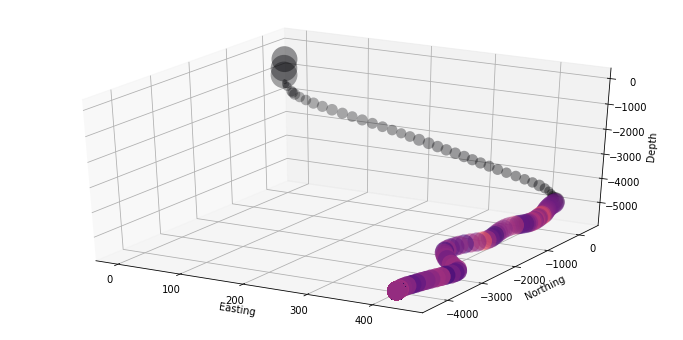

In [8]:
from mpl_toolkits.mplot3d import Axes3D

ax = plt.figure(figsize=plt.figaspect(0.5)*1.5).gca(projection="3d")
ax.scatter(
    easting,
    northing,
    -depth,
    c=plt.cm.magma(shaded),
    s=interpolated["azimuth"] * 2,
    edgecolors="none",
)
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
ax.set_zlabel("Depth")


Other things that would be fun to do with this kind of plot include plotting up an entire wellpad with 20+ wells at different stratigraphic heights or even add horizons in the plot for stratigraphic tops.

This notebook is licensed as CC-BY, use and share to your hearts content.